In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import random
import pennylane as qml
from silence_tensorflow import silence_tensorflow
silence_tensorflow()
from quantum_layer import quantum_layer

# Heat PDE for 2D with given BC and initial condition to predict at different time steps


The 2D heat equation is given by $$\frac{\partial u}{\partial t} = \alpha(\frac{\partial^2u}{\partial x^2} + \frac{\partial^2u}{\partial y^2})$$

In [2]:
num_points = 500 # Number of randomly sampled points for IC and BC
alpha = 15 # thermal diffusivity

# Define the range for time and spatial dimensions
t_min, t_max = 0, 1
x_min, x_max = 0, 1
y_min, y_max = 0, 1

# Generate random samples for the spatial and temporal ranges
x_samples = np.random.rand(num_points)
y_samples = np.random.rand(num_points)
t_samples = np.random.rand(num_points)

zeros = np.zeros(num_points)
ones = np.ones(num_points)

# [x, y, t, T]
 # Boundary top: u(x, y=1, t) = 100
boundary_top = np.vstack([x_samples, ones, t_samples, ones*100]).T
# Boundary right: u(x=1, y, t) = 0
boundary_right = np.vstack([ones, y_samples, t_samples, zeros]).T 
 # Boundary bottom: u(x, y=0, t) = 0
boundary_bottom = np.vstack([x_samples, zeros, t_samples,  zeros]).T
# Boundary left: u(x=0, y0, t) = 0
boundary_left = np.vstack([zeros, y_samples, t_samples, zeros]).T 
# IC u(x, y, t=0) = 0
initial_condition = np.vstack([x_samples, y_samples, zeros, zeros]).T 

initial_boundary_conditions = np.vstack([boundary_top, boundary_right, boundary_bottom, boundary_left, initial_condition])

x_initial_bc = initial_boundary_conditions[:, 0].astype(np.float32)
y_initial_bc = initial_boundary_conditions[:, 1].astype(np.float32)
t_initial_bc = initial_boundary_conditions[:, 2].astype(np.float32)
u_initial_bc = initial_boundary_conditions[:, 3].astype(np.float32)

In [3]:
u_initial_bc.shape

(2500,)

In [4]:
def loss_pde(x, y, t, net):
    # Convert inputs to tensors
    t = tf.constant(t, dtype=tf.float32)
    x = tf.constant(x, dtype=tf.float32)
    y = tf.constant(y, dtype=tf.float32)
    # print(x.shape)

    with tf.GradientTape(persistent=True) as tape:
        tape.watch(t)
        tape.watch(x)
        tape.watch(y)
        
        inputs = tf.stack([x, y, t], axis=1)
        u = net(inputs)
        
        u_t = tape.gradient(u, t)
        u_x = tape.gradient(u, x)
        u_xx = tape.gradient(u_x, x)
        u_y = tape.gradient(u, y)
        u_yy = tape.gradient(u_y, y)

    loss_pde = tf.reduce_mean((u_t - alpha * (u_xx + u_yy)) ** 2)
    
    del tape  # Explicitly delete the tape to release resources
    # print(loss_pde.dtype)
    return loss_pde
def ic_bc_loss(x, y, t, net, u_initial_bc):
    
    t = tf.constant(t, dtype=tf.float32)
    x = tf.constant(x, dtype=tf.float32)
    y = tf.constant(y, dtype=tf.float32)
    inputs = tf.stack([x, y, t], axis=1)
    u_initial_bc = tf.constant(u_initial_bc, dtype=tf.float32)

    u_predicted_initial = net(inputs)
    mse_loss = tf.keras.losses.MeanSquaredError()
    loss_ic_bc = mse_loss(u_predicted_initial, u_initial_bc)
    # print(u_initial_bc.dtype)

    return loss_ic_bc

In [5]:
## Neural Net

NN = tf.keras.models.Sequential([
    tf.keras.layers.Input((3,)),
    tf.keras.layers.Dense(units = 32, activation = 'tanh'),
    tf.keras.layers.Dense(units = 32, activation = 'tanh'),
    tf.keras.layers.Dense(units = 32, activation = 'tanh'),
    tf.keras.layers.Dense(units = 4, activation = 'tanh'),
    tf.keras.layers.Dense(units = 1)
])

NN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                128       
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dense_2 (Dense)             (None, 32)                1056      
                                                                 
 dense_3 (Dense)             (None, 4)                 132       
                                                                 
 dense_4 (Dense)             (None, 1)                 5         
                                                                 
Total params: 2377 (9.29 KB)
Trainable params: 2377 (9.29 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Epoch 0: Average Loss = 1982.162109375
Epoch 10: Average Loss = 1913.767578125
Epoch 20: Average Loss = 1865.308349609375
Epoch 30: Average Loss = 1854.756591796875
Epoch 40: Average Loss = 1841.9508056640625
Epoch 50: Average Loss = 1846.6510009765625
Epoch 60: Average Loss = 1833.105224609375
Epoch 70: Average Loss = 1822.137451171875
Epoch 80: Average Loss = 1815.819580078125
Epoch 90: Average Loss = 1806.443603515625
Epoch 100: Average Loss = 1793.0048828125
Epoch 110: Average Loss = 1794.6953125
Epoch 120: Average Loss = 1795.431884765625
Epoch 130: Average Loss = 1793.08203125
Epoch 140: Average Loss = 1781.323974609375
Epoch 150: Average Loss = 1783.4000244140625
Epoch 160: Average Loss = 1775.085205078125
Epoch 170: Average Loss = 1766.908935546875
Epoch 180: Average Loss = 1765.0775146484375
Epoch 190: Average Loss = 1760.250244140625
Epoch 200: Average Loss = 1751.409423828125
Epoch 210: Average Loss = 1745.7886962890625
Epoch 220: Average Loss = 1743.337890625
Epoch 230: Ave

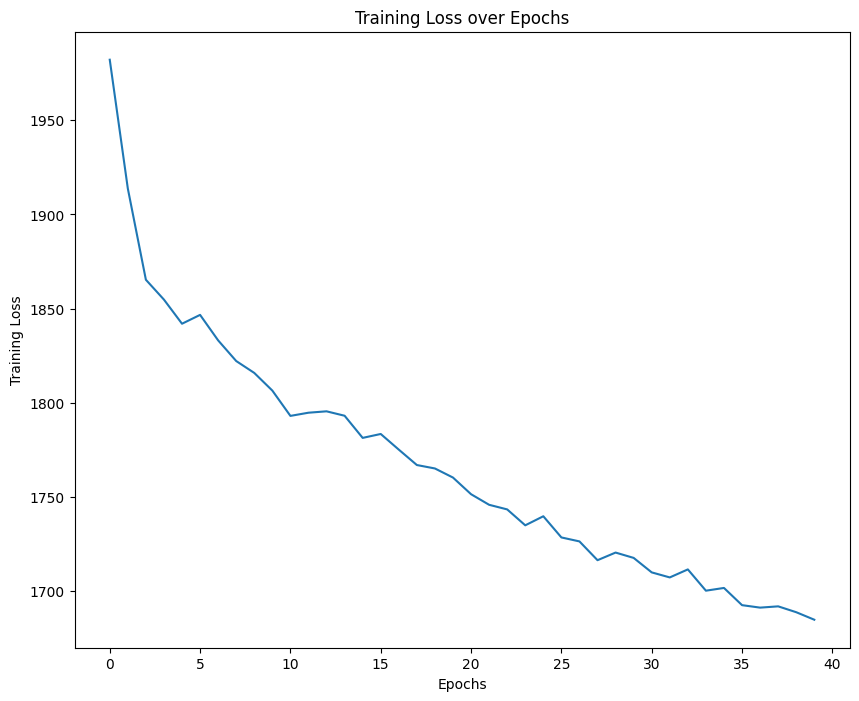

In [23]:
optm = tf.keras.optimizers.Adam(learning_rate = 0.0005)

# 15 points are chosen on which the ode loss is calculated 
train_loss_record = []
num_epochs = 400
batch_size = 256
num_batches = num_points // batch_size

## batching is done in order to make the training more effecient 
dataset = tf.data.Dataset.from_tensor_slices((x_initial_bc, y_initial_bc, t_initial_bc, u_initial_bc))
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size)

# Training loop
for itr in range(num_epochs):
    epoch_loss = 0.0
    num_batches = 0

    for batch in dataset:
        x_batch, y_batch, t_batch, u_batch = batch
        with tf.GradientTape() as tape:
            train_loss = loss_pde(x_batch, y_batch, t_batch, NN) + ic_bc_loss(x_batch, y_batch, t_batch, NN, u_batch)
        
        grad_w = tape.gradient(train_loss, NN.trainable_variables)
        optm.apply_gradients(zip(grad_w, NN.trainable_variables))
        
        # Accumulate the loss for each batch
        epoch_loss += train_loss
        num_batches += 1
    
    # Compute the average loss over all batches
    epoch_loss /= num_batches
    
    if itr % 10 == 0:
        train_loss_record.append(epoch_loss)
        print(f"Epoch {itr}: Average Loss = {epoch_loss.numpy()}")

plt.figure(figsize = (10, 8))
plt.plot(train_loss_record)
plt.xlabel("Epochs")
plt.ylabel("Training Loss")
plt.title("Training Loss over Epochs")
plt.show()

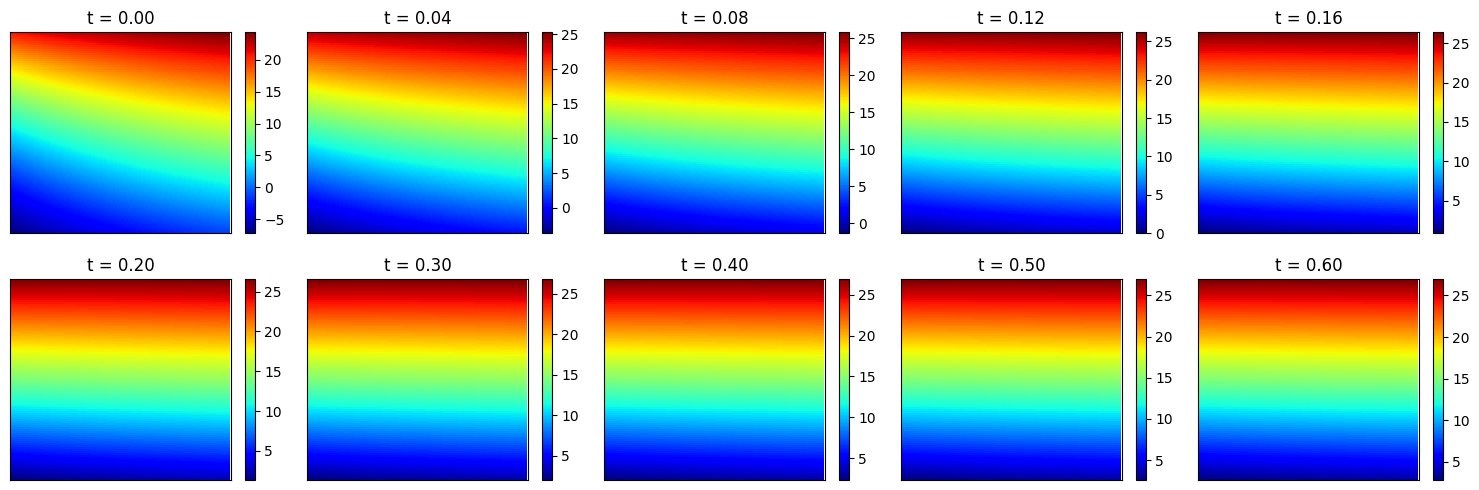

In [17]:
# Generate meshgrid for x and y
x = np.arange(x_min, x_max, 0.01)
y = np.arange(y_min, y_max, 0.01)
mesh_x, mesh_y = np.meshgrid(x, y)
x = np.ravel(mesh_x).reshape(-1, 1)
y = np.ravel(mesh_y).reshape(-1, 1)
period = [0,0.04,0.08,0.12, 0.16,0.2,.3,.4,.5,.6]


# Convert numpy arrays to TensorFlow tensors
pt_x = tf.Variable(tf.constant(x, dtype=tf.float32), trainable=True)
pt_y = tf.Variable(tf.constant(y, dtype=tf.float32), trainable=True)

# Create subplots
fig, axes = plt.subplots(2, 5, figsize=(15, 5))
# NN= NNClassical
# Iterate over periods
for index, axis in enumerate(axes.ravel()):
    t_value = period[index]

    t = np.full_like(x, period[index])
    pt_t = tf.Variable(tf.constant(t, dtype=tf.float32), trainable=True)

    # Forward pass through the neural network
    with tf.GradientTape() as tape:
        u = NN(tf.concat([pt_x, pt_y, pt_t], axis=1))  # Assuming net() takes concatenated inputs

    u = u.numpy()  # Convert TensorFlow tensor to numpy array
    mesh_u = u.reshape(mesh_x.shape)

    # Plotting
    cm = axis.pcolormesh(mesh_x, mesh_y, mesh_u, cmap='jet')
    fig.colorbar(cm, ax=axis)
    axis.set_xlim([x_min, x_max])
    axis.set_xticks([])
    axis.set_yticks([])
    axis.set_ylim([y_min, y_max])
    axis.set_title(f"t = {t_value:.2f}")  # Set subplot title with time value


fig.tight_layout()
plt.show()